In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input files
INPUT_DIR = "./DATA/PROCESSED"
INPUT_FILE_ADDITIONAL_PREPEND = ""
INPUT_FILE_DATA_PKL = 'POT_47N_2.5W_' + INPUT_FILE_ADDITIONAL_PREPEND + 'full_dataframe.pkl'
INPUT_FILE_OUTLIERS_PKL = 'POT_47N_2.5W_' + INPUT_FILE_ADDITIONAL_PREPEND + '95q_outliers_df.pkl'
INPUT_FILE_TRAIN_TS = 'POT_47N_2.5W_' + INPUT_FILE_ADDITIONAL_PREPEND + 'np_train_data.npz'

## Load data to pandas DataFrame

- Use pandas to store data as DataFrame object
- Drop time column because Kmeans requires only numeric data

In [3]:
df_wo_nan = pd.read_pickle(os.path.join(INPUT_DIR, INPUT_FILE_DATA_PKL))
outliers_dataframe = pd.read_pickle(os.path.join(INPUT_DIR, INPUT_FILE_OUTLIERS_PKL))
train_data = np.load(os.path.join(INPUT_DIR, INPUT_FILE_TRAIN_TS), allow_pickle=True)
print(f"Full dataset contains {df_wo_nan.shape[0]} observation points")
print(f"Outliers dataset contains {outliers_dataframe.shape[0]} observation points")
print(f"Train dataset contains {train_data['train_data'].shape} values")
print(f"Windows dataset contains {train_data['windows'].shape} values")
print(f"Timeseries dataset contains {train_data['timeseries'].shape} values")

Full dataset contains 727560 observation points
Outliers dataset contains 1237 observation points
Train dataset contains (1237, 216, 4) values
Windows dataset contains (1237, 2) values
Timeseries dataset contains (1237,) values


Longest timeseries is 216 hours long. Its index is 786
Shortest timeseries is 8 hours long. Its index is 1030
Median duration is 48.0 hours long.


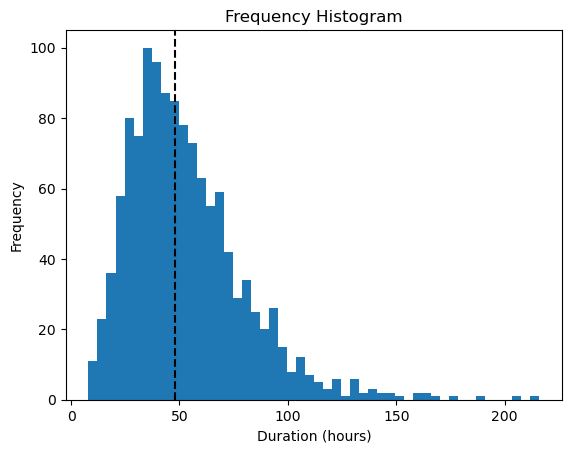

In [4]:
timeseries = train_data['timeseries'].tolist()
windows = train_data['windows']
full_train_data = train_data['train_data'] # Careful that variables to keep are in right order

ts_length = [len(ts) for ts in timeseries]
max_length = max(ts_length)
first_max = next(filter(lambda ts: len(ts) >= max_length, timeseries), None)
max_idx = next((i for i, val in enumerate(timeseries) if np.array_equal(val,first_max)), -1)
first_min = next(filter(lambda ts: len(ts) == np.min(ts_length), timeseries), None)
min_idx = next((i for i, val in enumerate(timeseries) if np.array_equal(val,first_min)), -1)
print(f"Longest timeseries is {np.max(ts_length)} hours long. Its index is {max_idx}")
print(f"Shortest timeseries is {np.min(ts_length)} hours long. Its index is {min_idx}")
print(f"Median duration is {np.median(ts_length)} hours long.")
plt.hist(ts_length, bins=50)
plt.axvline(np.median(ts_length), color="black", ls="--", label="Median duration")
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Duration (hours)');

## Compute metrics to find optimum cluster number

Reshape input data with respect to KMeans constraints that expects a 2-dimensional matrix

In [5]:
reshape_data = full_train_data.reshape(full_train_data.shape[0], -1)
print(reshape_data.shape)

(1237, 864)


In [6]:
from sklearn import metrics
from sklearn.cluster import KMeans

from pycvi.cvi_func import davies_bouldin
from pycvi.cluster import get_clustering
import timeit

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 100,
    "max_iter": 100,
    "random_state": None,
}

# A list holds the SSE values for each k
inertia = []
db_scores = []
clusters = range(3, 12)
for k in clusters:
    start = timeit.default_timer()
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    result = kmeans.fit_predict(reshape_data)
    inertia.append(kmeans.inertia_)
    clusters_pred = get_clustering(result)
    db_score = davies_bouldin(reshape_data, clusters_pred)
    db_scores.append(db_score)
    
    stop = timeit.default_timer()
    execution_time = stop - start
    print(f"Test with {k} clusters: Inertia is {round(kmeans.inertia_, 2)}, DB score is {round(db_score, 2)}. Execution time: {execution_time}")

Test with 3 clusters: Inertia is 9449.05, DB score is 1.36. Execution time: 3.1130152929999895
Test with 4 clusters: Inertia is 7937.22, DB score is 1.42. Execution time: 3.1932945850003307
Test with 5 clusters: Inertia is 6981.67, DB score is 1.4. Execution time: 3.615665497000009
Test with 6 clusters: Inertia is 6271.8, DB score is 1.48. Execution time: 3.6186713030001556
Test with 7 clusters: Inertia is 5866.0, DB score is 1.73. Execution time: 3.122770780000792
Test with 8 clusters: Inertia is 5515.69, DB score is 1.72. Execution time: 3.49392666499989
Test with 9 clusters: Inertia is 5253.42, DB score is 1.77. Execution time: 5.876735044999805
Test with 10 clusters: Inertia is 5029.38, DB score is 1.77. Execution time: 5.46062005100066
Test with 11 clusters: Inertia is 4862.25, DB score is 1.77. Execution time: 6.393385352999758


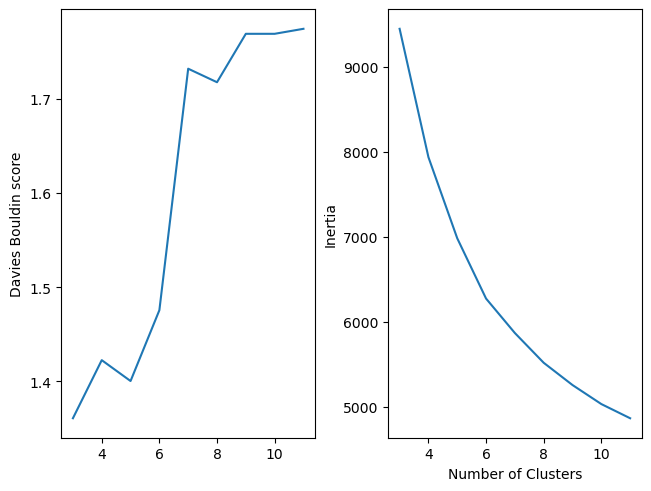

In [7]:
_, axes = plt.subplots(1, 2, layout='constrained', sharex=True)
axes[0].plot(clusters, db_scores)
axes[1].plot(clusters, inertia)
axes[1].set_ylabel('Inertia')
axes[0].set_ylabel('Davies Bouldin score')
plt.xlabel("Number of Clusters")
plt.show()

## Train KMeans model

- train KMeans using euclidean distance with 5 clusters and store result as hdf5 file
- if already trained, one can load result from `model_dir` by setting `TRAINED` to `True`

In [7]:
import pickle

N_CLUSTERS = 4
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 100,
    "max_iter": 100,
    "random_state": None,
}

TRAINED = True
KM_MODEL_FILEPATH = "./model_dir/kmeans_ed.pkl"

if TRAINED:
    with open(KM_MODEL_FILEPATH, 'rb') as file:
        km = pickle.load(file)
        result = km.labels_
else:
    start = timeit.default_timer()
    km = KMeans(n_clusters=N_CLUSTERS, **kmeans_kwargs)
    result = km.fit_predict(reshape_data)
    clusters_pred = get_clustering(result)
    db_score = davies_bouldin(reshape_data, clusters_pred)
    stop = timeit.default_timer()
    execution_time = stop - start
    if os.path.exists(KM_MODEL_FILEPATH):
        os.remove(KM_MODEL_FILEPATH)
    pickle.dump(km, open(KM_MODEL_FILEPATH, 'wb'))
    print(f"Test with {N_CLUSTERS} clusters: Inertia is {round(km.inertia_, 2)}, DB score is {round(db_score, 2)}. Execution time: {execution_time}")

## Plot clusters with known events

- plot each cluster and variables separately
- plot known events in the cluster they belong to

In [8]:
from datetime import datetime

storm_dates = [
    [datetime(1999, 12, 23), datetime(1999, 12, 31)],
    [datetime(2010, 2, 25), datetime(2010, 3, 2)],
    [datetime(2023, 10, 26), datetime(2023, 11, 1)],
]
lm_samples = []
xynthia_samples = []
celine_samples = []

def get_points_from_window(window, dataframe, max_length):
    window_length = (window[1] - window[0]).days
    rows = dataframe[(dataframe['date'] >= window[0]) & (dataframe['date'] <= window[1])]
    points = rows.drop(columns=['date']).to_numpy()
    # Slice window if it exceeds max supposed length
    if len(points) > max_length:
        return points[:max_length]
    else:
        return points

for window in windows:
    if window[0] >= storm_dates[0][0] and window[1] <= storm_dates[0][1]:
        lm_samples.append(get_points_from_window(window, df_wo_nan, max_length))
    if window[0] >= storm_dates[1][0] and window[1] <= storm_dates[1][1]:
        xynthia_samples.append(get_points_from_window(window, df_wo_nan, max_length))
    if window[0] >= storm_dates[2][0] and window[1] <= storm_dates[2][1]:
        celine_samples.append(get_points_from_window(window, df_wo_nan, max_length))

print(f"Lothar&Martin has {len(lm_samples)} corresponding timeseries in the dataset")
print(f"Xynthia has {len(xynthia_samples)} corresponding timeseries in the dataset")
print(f"Celine has {len(celine_samples)} corresponding timeseries in the dataset")

Lothar&Martin has 1 corresponding timeseries in the dataset
Xynthia has 1 corresponding timeseries in the dataset
Celine has 1 corresponding timeseries in the dataset


In [9]:
STORM = 0
# Get index of corresponding windows in initial list
def get_storm_cluster(storm_number: int):
    selected_windows = []
    selected_index = []
    for idx, window in enumerate(windows):
        check = (window[0].date() >= storm_dates[storm_number][0].date() and window[1].date() <= storm_dates[storm_number][1].date())
        if check:
            selected_windows.append((idx, window))
            selected_index.append(idx)
    return (selected_windows, km.labels_[selected_index[0]])

print(get_storm_cluster(STORM))

([(822, array([Timestamp('1999-12-23 14:00:00'), Timestamp('1999-12-30 11:00:00')],
      dtype=object))], 1)


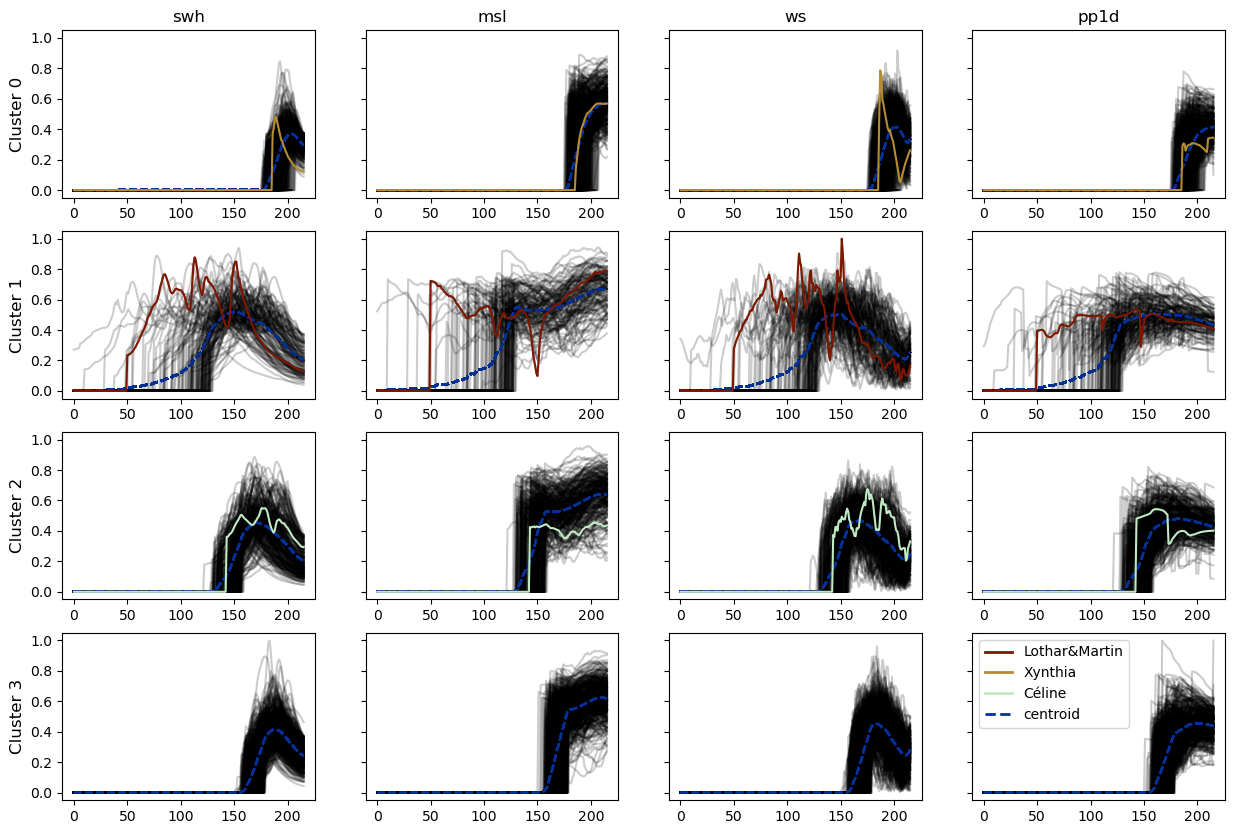

In [22]:
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.lines import Line2D
from cmcrameri import cm

VARIABLES = df_wo_nan.columns[1:]
N_VARIABLES = len(VARIABLES)

## Define blindness-compliant colors
colors = cm.roma(np.linspace(0, 1, 9))

fig, axs = plt.subplots(N_CLUSTERS, N_VARIABLES, figsize=(15, 10), sharey=True)
for yi in range(N_CLUSTERS):
    centroid = km.cluster_centers_[yi].reshape(full_train_data[0].shape[0], 4) # get back to a 2D array
    for xx in full_train_data[result == yi]:
        for d in range(N_VARIABLES):
            axs[yi][d].plot(xx[:, d], "k-", alpha=.2)
            axs[yi][d].plot(centroid[:, d], "--", color=colors[-1], label="Centroid")

## Plot known storms
for i in range(3):
    storm_infos = get_storm_cluster(i)
    storm_cluster = int(storm_infos[1])
    storm_index = storm_infos[0][0][0]
    poi_ref = timeseries[storm_index].tolist()
    padded_storm_data = np.pad(poi_ref, ((max_length - len(poi_ref), 0), (0, 0)))
    
    for d in range(N_VARIABLES):
        axs[storm_cluster][d].plot(padded_storm_data[:, d], color=colors[2*i], alpha=1)

# Display titles for columns and rows
cols = VARIABLES
rows = [f'Cluster {k}' for k in range(N_CLUSTERS)]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

# Custom legend for article guidelines
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='Line'),
                   Line2D([0], [0], color=colors[2], lw=2, label='Line'),
                   Line2D([0], [0], color=colors[4], lw=2, label='Line'),
                   Line2D([0], [0], color=colors[-1], linestyle="--", lw=2, label='Line'),]
plt.legend(legend_elements, ['Lothar&Martin', 'Xynthia', 'Céline', 'centroid'])

plt.savefig("FIGS/KM_ED_clusters.pdf", dpi=300, bbox_inches='tight')

## Plot cluster frequency over time


/home/hervy-b/miniconda3/envs/timeseries-clustering/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


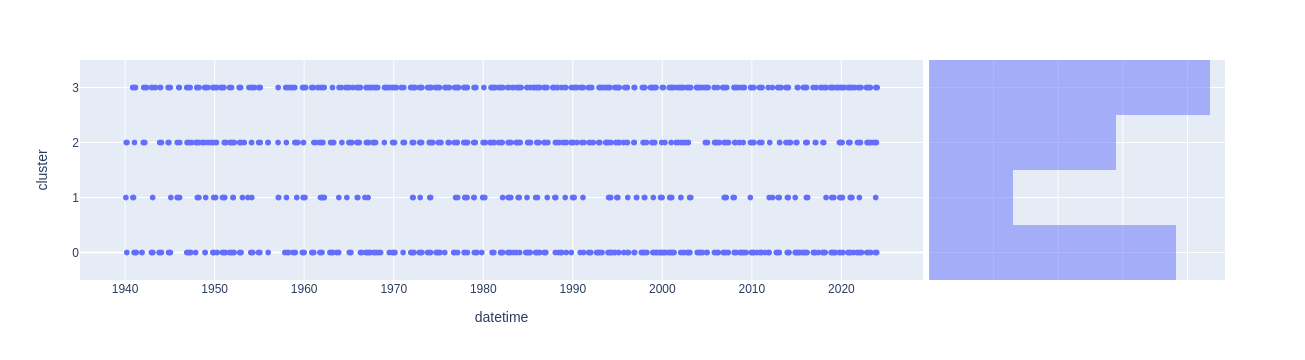

In [12]:
import plotly.express as px

# append dtw kmeans clustering result to initial dataframe

plot_df = pd.DataFrame(data=zip(windows[:,0], result), columns=['datetime', 'cluster'])
fig = px.scatter(plot_df, x="datetime", y="cluster", marginal_y="histogram")
fig.show()

## Clustering IRSN database storm records

- URL : https://bddtsh.irsn.fr/
- Check cluster number for storm events/submersion listed by french consortium over the past 100 years

### Read input csv file

- Drop rows with NaN values
- Get datetime from columns Year, Month, Day
- Drop events before 1940

In [13]:
df = pd.DataFrame(data=km.labels_, columns=["cluster"])

In [14]:
bddtsh = pd.read_csv("DATA/BDD-TSH-IRSN.csv", sep=";")
bddtsh = bddtsh.dropna()
bddtsh = bddtsh[bddtsh.Annee > 1940]
bddtsh['date'] = pd.to_datetime(dict(year=bddtsh.Annee, month=bddtsh.Mois, day=bddtsh.Jour))
print(bddtsh.head())
print(f"{len(bddtsh)} remaining events at this stage")

    Jour  Mois  Annee       date
34  16.0   2.0   1941 1941-02-16
35  12.0   1.0   1943 1943-01-12
36   9.0  12.0   1946 1946-12-09
37  28.0  12.0   1947 1947-12-28
38  27.0   1.0   1948 1948-01-27
75 remaining events at this stage


### Find corresponding timeseries and cluster

- find the series that contains each event's datetime
- find corresponding cluster when possible

In [15]:
import itertools

# For each storm, get corresponding window if it exists and the cluster number
series_numbers = []
cluster_numbers = []
for storm_date in bddtsh['date']:
    # Get index of corresponding windows in initial list
    selected_windows = []
    for idx, window in enumerate(windows):
        check = (window[0].date() <= storm_date.date() and window[1].date() >= storm_date.date())
        if check:
            selected_windows.append((idx, window))
    if len(selected_windows) >= 1:
        series_numbers.append(int(selected_windows[0][0]))
        cluster = df.iloc[selected_windows[0][0]]["cluster"]
        cluster_numbers.append(int(cluster))
    else:
        series_numbers.append(None)
        cluster_numbers.append(None)
        
bddtsh["window"] = series_numbers
bddtsh["cluster"] = cluster_numbers
bddtsh = bddtsh.dropna()
print(f"{len(bddtsh)} remaining events at this stage")

# Get the list of storm events within the same clusters
duplicates = bddtsh.duplicated(subset='window', keep='first')
groupes = bddtsh.groupby('window').groups

# Duplicates couples list
couples_indices = []
for valeur, indices in groupes.items():
    if len(indices) > 1:
        couples = list(itertools.combinations(indices, 2))
        couples_indices.extend(couples)
print(f"{duplicates.sum()} duplicates in the list: {couples_indices}")

# Drop those indices
indices_a_supprimer = set()
for couple in couples_indices:
    indices_a_supprimer.add(couple[1])  # On supprime le deuxième élément de chaque couple

bddtsh_wo_duplicates = bddtsh.drop(set([d[1] for d in couples_indices]))
len(bddtsh_wo_duplicates)

62 remaining events at this stage


### Event distribution within clusters

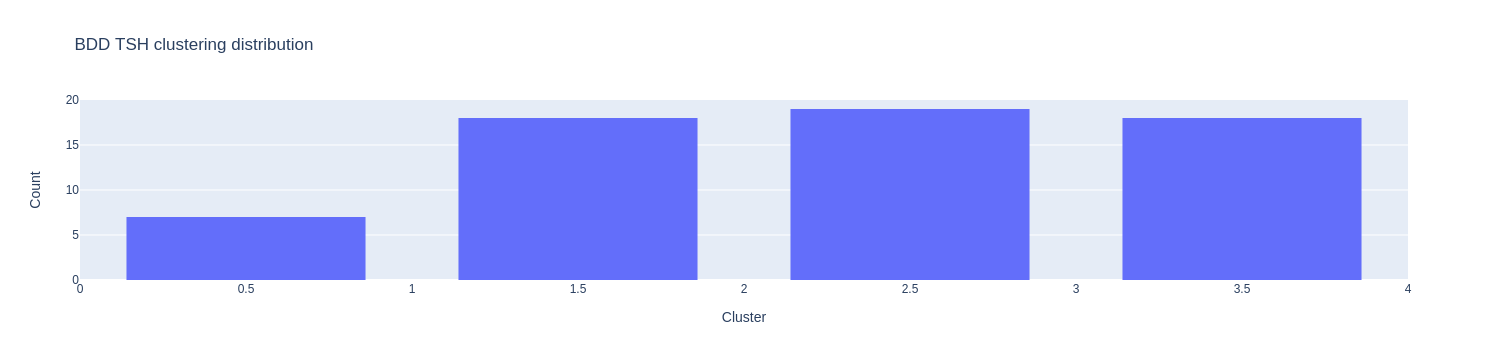

In [16]:
import plotly.graph_objects as go

# Get non Nan rows
bddtsh_wo_nan = bddtsh_wo_duplicates.dropna()
# Plot histogram
fig = go.Figure(
    go.Histogram(
    x=bddtsh_wo_nan['cluster'],
    xbins=dict( # bins used for histogram
        start=0,
        end=10,
        size=1
    ),
    opacity=1
))
fig.update_layout(
    title_text='BDD TSH clustering distribution', # title of plot
    xaxis_title_text='Cluster', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

/home/hervy-b/miniconda3/envs/timeseries-clustering/lib/python3.11/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/hervy-b/miniconda3/envs/timeseries-clustering/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



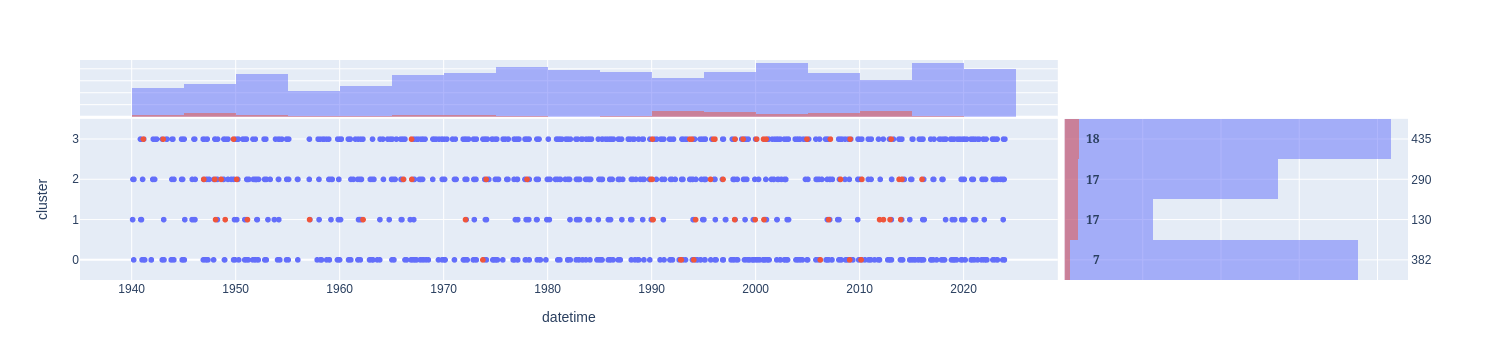

In [17]:
import plotly.express as px
import plotly.io as pio

plot_df = pd.DataFrame(data=zip(windows[:,0], clustering_result), columns=['datetime', 'cluster'])
# Append 1 if series is in BDDTSH, 0 otherwise
plot_df['bddtsh'] = plot_df.index.isin(bddtsh['window'].values).astype(str)
fig = px.scatter(plot_df, x="datetime", y="cluster", color="bddtsh", symbol="bddtsh", 
                 color_discrete_sequence=px.colors.qualitative.T10, marginal_x="histogram", marginal_y="histogram")

fig.update_layout(showlegend=False)
# Add annotations to histograms
hist_y = plot_df['cluster'].value_counts()
hist_y_true = plot_df[plot_df['bddtsh'] == 'True']['cluster'].value_counts()
for i, (cluster, count) in enumerate(hist_y.items()):
    fig.add_annotation(x=1, y=cluster, text=str(count), showarrow=False, xref='paper', yref='y')
for i, (cluster, count) in enumerate(hist_y_true.items()):
    fig.add_annotation(x=0.77, y=cluster, text=f'<b>{count}</b>', showarrow=False, xref='paper', yref='y', font=dict(family='Bold'))

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    autosize=False,
    width=1200,
    height=300,
    showlegend=False,
    font=dict(
        size=18,
    )
)
pio.write_image(fig, "FIGS/KM_ED_cluster_time_bddtsh.png", validate=True, scale=1)
fig.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
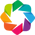

:Chord   [source,target]   (value)

In [19]:
import holoviews as hv
from holoviews import opts, dim

hv.extension('bokeh')
hv.output(size=200)

nodes = bddtsh_wo_nan
groups = {}

# Construct links
for ind in bddtsh_wo_nan.index:
    if bddtsh_wo_nan['cluster'][ind] in groups.keys():
        groups[bddtsh_wo_nan['cluster'][ind]].append(bddtsh_wo_nan['date'][ind])
    else:
        groups[bddtsh_wo_nan['cluster'][ind]] = [bddtsh_wo_nan['date'][ind]]

links = []
for g in groups.keys():
    for d in groups[g][:]:
        links.extend([[d, d2, 1] for d2 in groups[g] if d != d2])
        groups[g].remove(d)

links = pd.DataFrame(links, columns=['source', 'target', 'value'])
nodes = hv.Dataset(nodes, 'date', 'cluster')
chord = hv.Chord((links, nodes))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', labels='date', node_color=dim('cluster').str()))
